In [2]:
library(tidyverse)
library(jsonlite)
library(ggplot2)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘jsonlite’


The following object is masked from ‘package:purrr’:

    flatten




# Data Munging (for GPS and Weather)

In [3]:
gps_raw <- list()
for (file in list.files('gps')) {
    gps_raw[[file]] <- fromJSON(paste('gps/', file, sep=''), simplifyVector=TRUE)
}

In [6]:
# now pull out the coordinates
coords <- map(gps_raw, function (data) {t(simplify2array(data$features$geometry$coordinates))})

In [7]:
head(gps_raw[[1]]$features$properties$time)

[1] "2020-08-18T17:50:42.000Z" "2020-08-18T17:50:40.943Z"
[3] "2020-08-18T17:51:49.000Z" "2020-08-18T17:52:24.000Z"
[5] "2020-08-18T17:53:12.000Z" "2020-08-18T17:53:11.848Z"

In [89]:
head(coords[[1]])

-114.0003,46.88678
-114.0005,46.88632
-113.9999,46.88604
-113.9992,46.88620
-113.9978,46.88587
-113.9972,46.88593


In [8]:
days_dfs <- map(names(gps_raw), function(name) {
    data.frame(time =strptime(gps_raw[[name]]$features$properties$time,format = "%Y-%m-%dT%H:%M:%S", tz="UTC"),
               longitude = coords[[name]][,1],
               latitude = coords[[name]][,2])
})
names(days_dfs) <- names(gps_raw)

In [9]:
head(days_dfs[[1]], 3)
tail(days_dfs[[11]], 2)

,time,longitude,latitude
,<dttm>,<dbl>,<dbl>
1,2020-08-18 17:50:42,-114.0003,46.88678
2,2020-08-18 17:50:40,-114.0005,46.88632
3,2020-08-18 17:51:49,-113.9999,46.88604


,time,longitude,latitude
,<dttm>,<dbl>,<dbl>
866,2020-08-31 22:48:46,-114.0002,46.88728
867,2020-08-31 22:48:55,-114.0001,46.88740


### Process Weather Data

In [10]:
weather_raw <- fromJSON('historical_weather.json', simplifyVector=TRUE)
weather_obs <- weather_raw$observations
head(weather_obs)
colnames(weather_obs)
temperature_all <- weather_obs[, c('valid_time_gmt', 'temp')]

,key,class,expire_time_gmt,obs_id,obs_name,valid_time_gmt,day_ind,temp,wx_icon,icon_extd,⋯,clds,water_temp,primary_wave_period,primary_wave_height,primary_swell_period,primary_swell_height,primary_swell_direction,secondary_swell_period,secondary_swell_height,secondary_swell_direction
,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<int>,⋯,<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
1,KMSO,observation,1597567980,KMSO,Missoula,1597560780,N,60,33,3300,⋯,CLR,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,KMSO,observation,1597571580,KMSO,Missoula,1597564380,N,61,33,3300,⋯,CLR,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,KMSO,observation,1597575180,KMSO,Missoula,1597567980,N,57,33,3300,⋯,CLR,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,KMSO,observation,1597578780,KMSO,Missoula,1597571580,N,54,33,3300,⋯,CLR,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,KMSO,observation,1597582380,KMSO,Missoula,1597575180,N,50,33,3300,⋯,CLR,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,KMSO,observation,1597585980,KMSO,Missoula,1597578780,N,48,33,3300,⋯,CLR,NA,NA,NA,NA,NA,NA,NA,NA,NA


[1] "key"                       "class"                    
 [3] "expire_time_gmt"           "obs_id"                   
 [5] "obs_name"                  "valid_time_gmt"           
 [7] "day_ind"                   "temp"                     
 [9] "wx_icon"                   "icon_extd"                
[11] "wx_phrase"                 "pressure_tend"            
[13] "pressure_desc"             "dewPt"                    
[15] "heat_index"                "rh"                       
[17] "pressure"                  "vis"                      
[19] "wc"                        "wdir"                     
[21] "wdir_cardinal"             "gust"                     
[23] "wspd"                      "max_temp"                 
[25] "min_temp"                  "precip_total"             
[27] "precip_hrly"               "snow_hrly"                
[29] "uv_desc"                   "feels_like"               
[31] "uv_index"                  "qualifier"                
[33] "qualifier_svrty"           "blunt_phrase"             
[35] "terse_phrase"              "clds"                     
[37] "water_temp"                "primary_wave_period"      
[39] "primary_wave_height"       "primary_swell_period"     
[41] "primary_swell_height"      "primary_swell_direction"  
[43] "secondary_swell_period"    "secondary_swell_height"   
[45] "secondary_swell_direction"

In [11]:
# verify observations are once every hour
temperature_all[2:6, 1] - temperature_all[1:5, 1]

[1] 3600 3600 3600 3600 3600

# Put Data Together & Explore

In [12]:
# now heap coordinates together with flag for their day
num_total <- sum(unlist(lapply(days_dfs, function(df) {return(dim(df)[1])})))
num_total
reduced_df <- data.frame(
    index=unlist(lapply(days_dfs, function(df) {return(1:length(df$time))})),
    time=unlist(lapply(days_dfs, function(df) {return(df$time)})),
    elapsed=unlist(lapply(days_dfs, function(df) {return(df$time - df$time[1])})),
    longitude=unlist(lapply(days_dfs, function(df) {return(df$longitude)})),
    latitude=unlist(lapply(days_dfs, function(df) {return(df$latitude)})),
    day=factor(unlist(lapply(1:length(days_dfs),
                                    function(idx) {return(rep(idx, length(days_dfs[[idx]]$longitude)))}
                                   )))
)

[1] 5857

In [13]:
# now get UTM coordinates
library(sp)
spat_df <-SpatialPointsDataFrame(coords=reduced_df[,c("longitude", "latitude")],
                                 data=reduced_df["time"],
                                 proj4string=CRS("+proj=longlat +datum=WGS84 +units=m"))# This step converts the longitude/latitude -> UTM
utm_df <-spTransform(spat_df, CRSobj = "+proj=utm +zone=12 +datum=WGS84 +units=m")
utm_coords <- coordinates(utm_df)
reduced_df$lat_m <- utm_coords[, "latitude"]
reduced_df$long_m <- utm_coords[, "longitude"]

In [14]:
# now pair data to temperature via linear interpolation
indices <- unlist(lapply(reduced_df$time, function(time) {which(temperature_all[, 1] > time)[1]}))
first_temp <- temperature_all[indices-1, 2]
second_temp <- temperature_all[indices, 2]
# now interpolate
diff <- temperature_all[indices, 1] - temperature_all[indices-1, 1]
weight <- (reduced_df$time - temperature_all[indices-1, 1])/diff
final_temps <- first_temp*(1-weight) + second_temp*weight

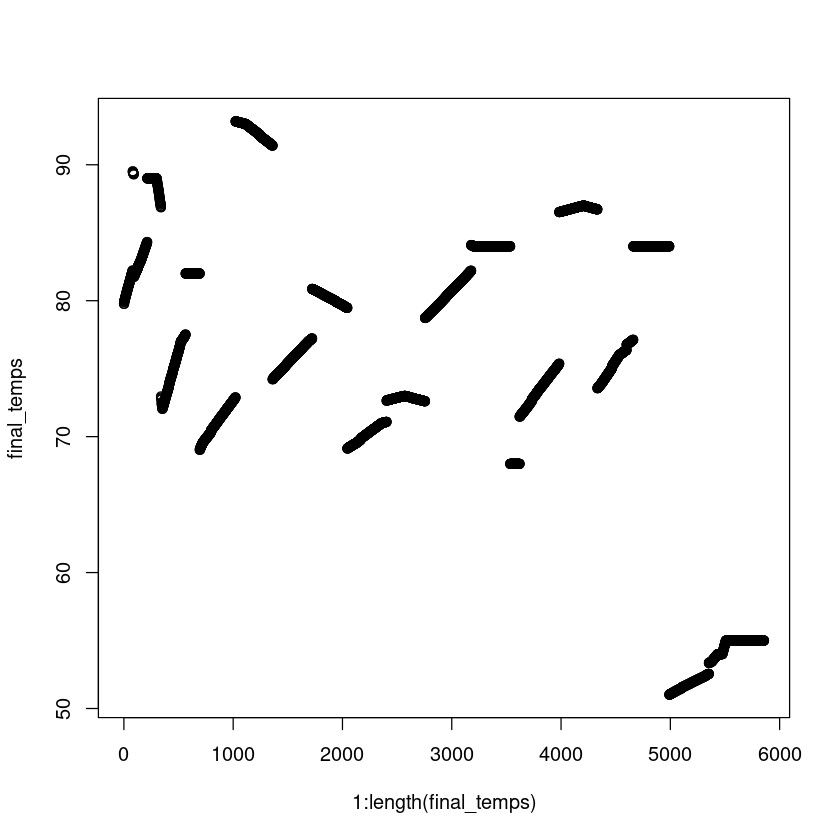

In [15]:
plot(1:length(final_temps), final_temps)

In [16]:
# now add temperature to dataframe
reduced_df$temperature <- final_temps

In [17]:
head(reduced_df)

,index,time,elapsed,longitude,latitude,day,lat_m,long_m,temperature
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>
20200818114606.geojson1,1,1597773042,0,-114.0003,46.88678,1,5196954,271422.2,79.77000
20200818114606.geojson2,2,1597773040,-2,-114.0005,46.88632,1,5196903,271407.1,79.76667
20200818114606.geojson3,3,1597773109,67,-113.9999,46.88604,1,5196870,271456.3,79.88167
20200818114606.geojson4,4,1597773144,102,-113.9992,46.88620,1,5196886,271504.3,79.94000
20200818114606.geojson5,5,1597773192,150,-113.9978,46.88587,1,5196845,271614.3,80.01000
20200818114606.geojson6,6,1597773191,149,-113.9972,46.88593,1,5196850,271656.7,80.00917


Warning message:
“Removed 114 rows containing missing values (geom_point).”


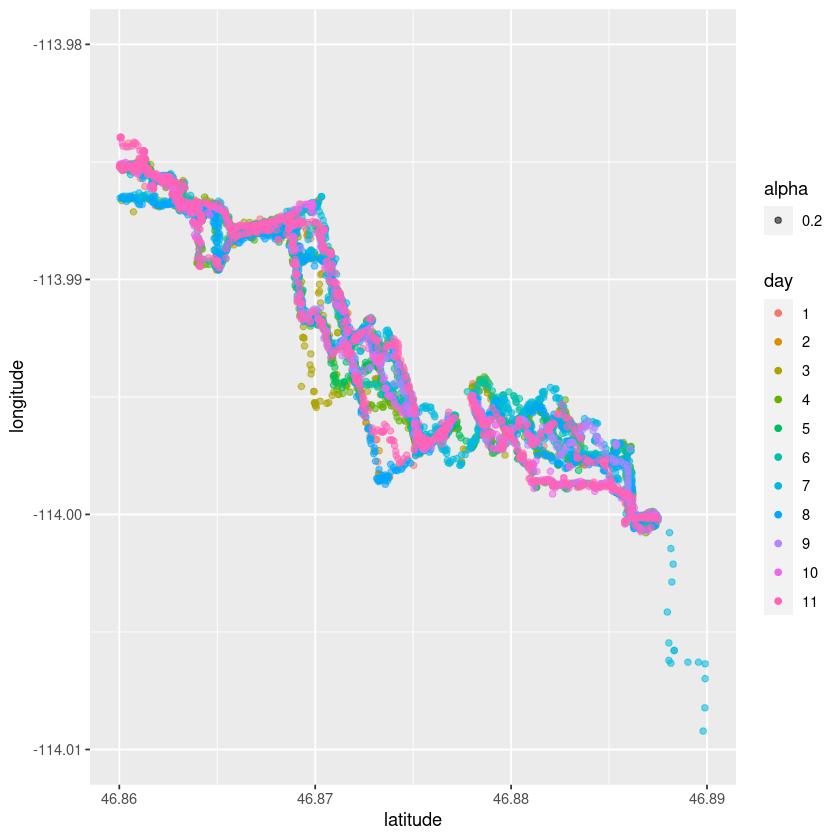

In [18]:
ggplot(reduced_df, aes(x=latitude, y=longitude, color=day, alpha=0.2)) +
    geom_point() +
    ylim(-114.01, -113.98) +
    xlim(46.86, 46.89)

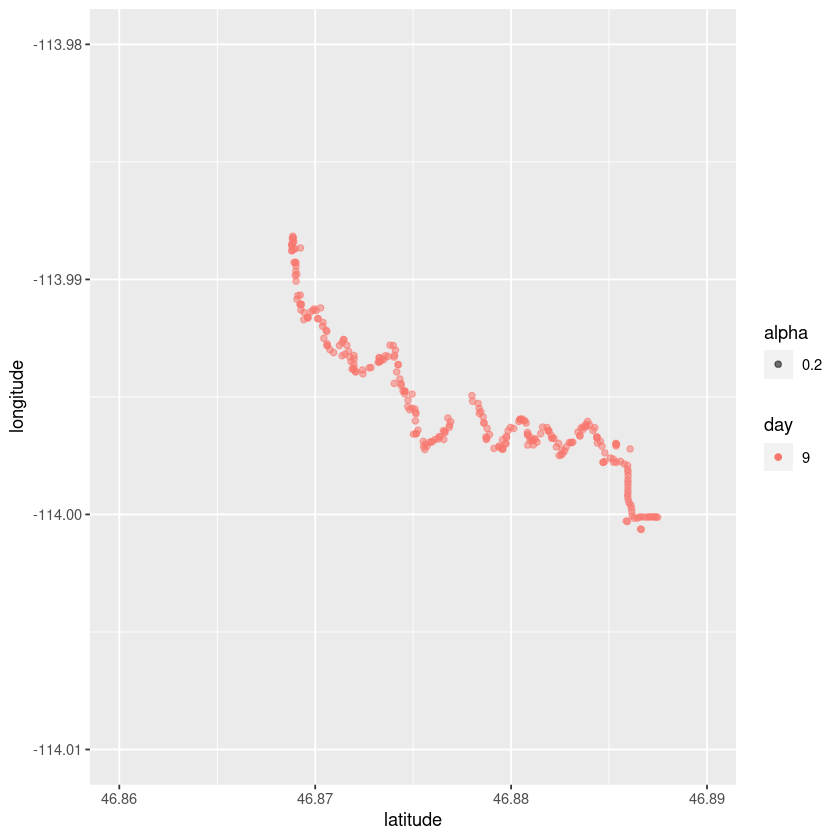

In [19]:
ggplot(reduced_df[reduced_df$day == 9, ], aes(x=latitude, y=longitude, color=day, alpha=0.2)) +
    geom_point() +
    ylim(-114.01, -113.98) +
    xlim(46.86, 46.89)

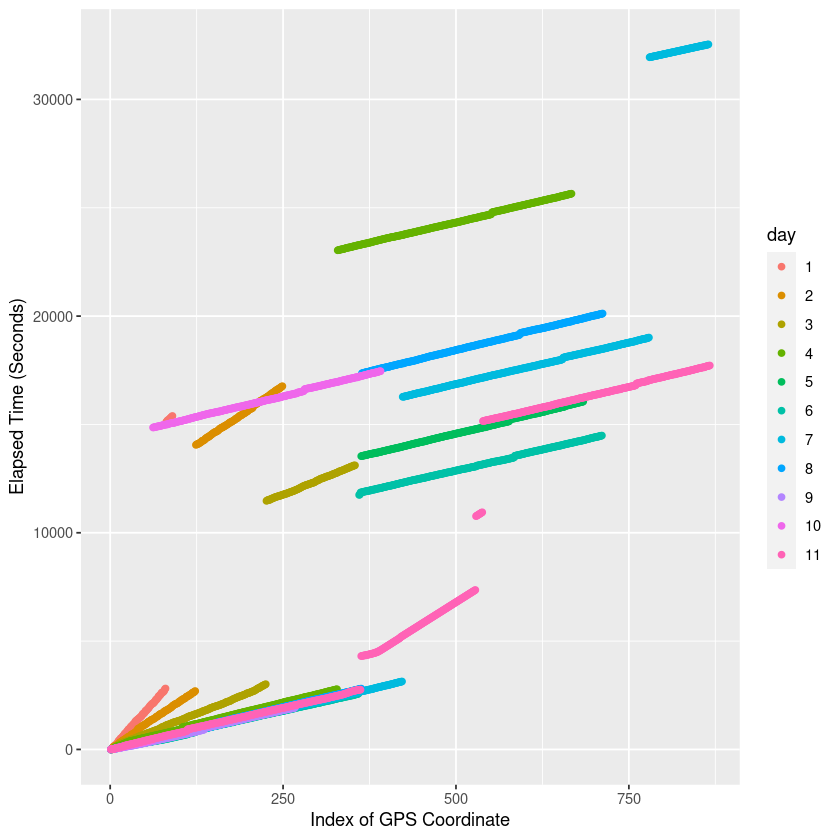

In [20]:
# now analyze in the time dimension
ggplot(reduced_df, aes(x=index, y=elapsed, color=day)) +
    geom_point() +
    ylab("Elapsed Time (Seconds)") +
    xlab("Index of GPS Coordinate")

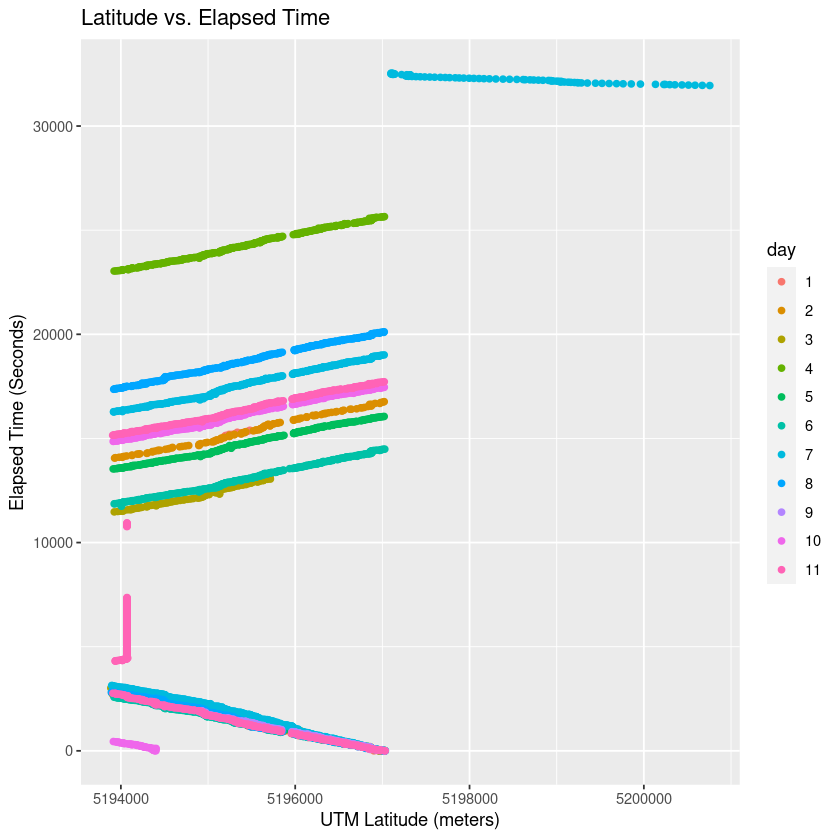

In [21]:
# now analyze in the time dimension
ggplot(reduced_df, aes(x=lat_m, y=elapsed, color=day)) +
    geom_point() +
    labs(title="Latitude vs. Elapsed Time",
         y="Elapsed Time (Seconds)",
         x="UTM Latitude (meters)")

In [22]:
length(days_dfs)

[1] 11

In [23]:
# now map "bombable" times
diff_time <- reduced_df$time[2:length(reduced_df$time)] - reduced_df$time[1:(length(reduced_df$time)-1)]
stationary <- c(TRUE, diff_time > 2*60)
reduced_df$stationary <- stationary
# TODO: MAKE IT CHECK IF YOU ARE LESS THAN 5 MINUTES FROM LAST STATIONARY
time_to_stationary <- unlist(map(reduced_df$time, function(time) {
    stat_diff <- time - reduced_df$time[reduced_df$stationary]
    ifelse(length(stat_diff[stat_diff >= 0]) != 0, min(stat_diff[stat_diff >= 0]), 0)
}))
reduced_df$bombable <- time_to_stationaryationary > 5*60

Warning message:
“Using alpha for a discrete variable is not advised.”
Warning message:
“Removed 57 rows containing missing values (geom_point).”


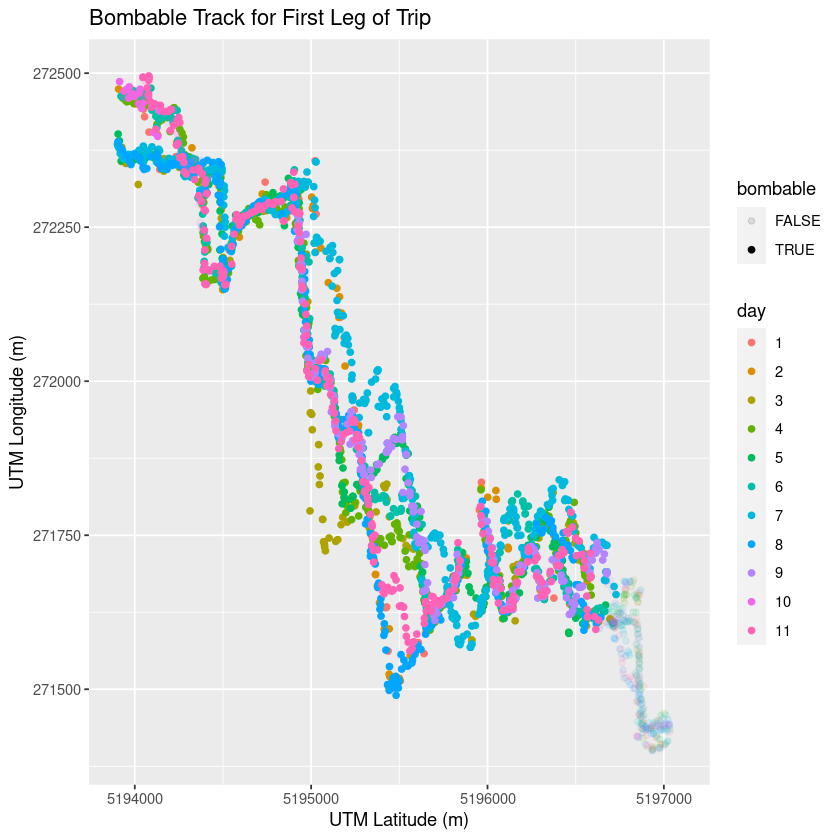

In [24]:
# plot hiding the non-bombable points
bombable <- ifelse(reduced_df$bombable, 0.9, 0.1)
ggplot(reduced_df[reduced_df$elapsed < 5000, ], aes(x=lat_m, y=long_m, color=day, alpha=bombable)) +
    geom_point() +
    ylim(271400, 272500) +
    xlim(5193900, 5197100) +
    labs(title="Bombable Track for First Leg of Trip",
         y="UTM Longitude (m)", x="UTM Latitude (m)")

Warning message:
“Using alpha for a discrete variable is not advised.”
Warning message:
“Removed 2171 rows containing missing values (geom_point).”


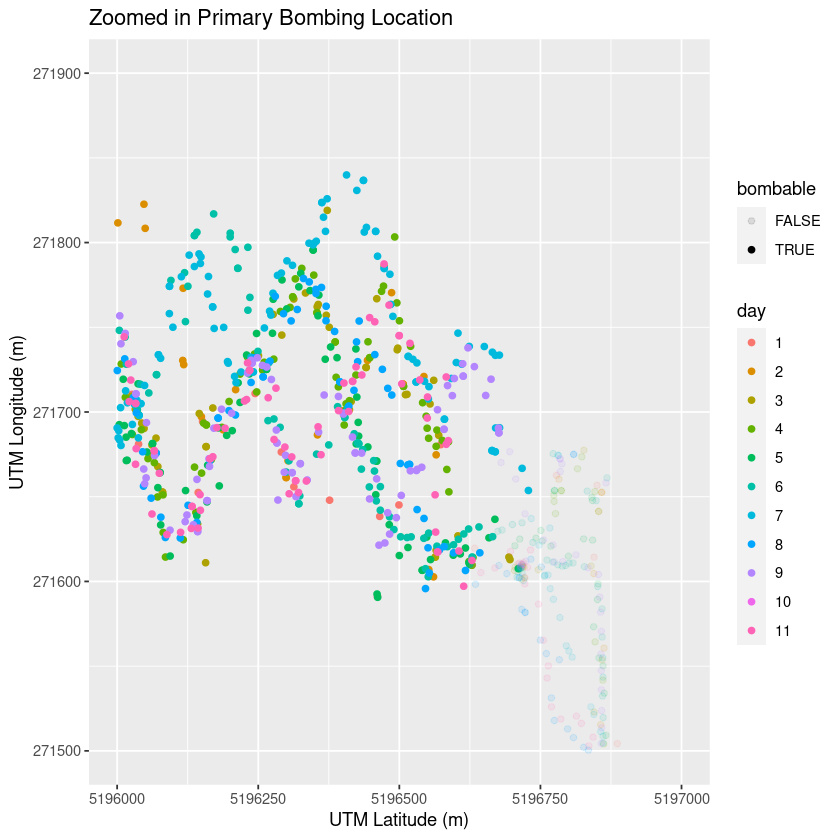

In [25]:
# plot hiding the non-bombable points
bombable <- ifelse(reduced_df$bombable, 0.9, 0.1)
ggplot(reduced_df[reduced_df$elapsed < 5000, ], aes(x=lat_m, y=long_m, color=day, alpha=bombable)) +
    geom_point() +
    ylim(271500, 271900) +
    xlim(5196000, 5197000) +
    labs(title="Zoomed in Primary Bombing Location",
         y="UTM Longitude (m)", x="UTM Latitude (m)")

Warning message:
“Using alpha for a discrete variable is not advised.”


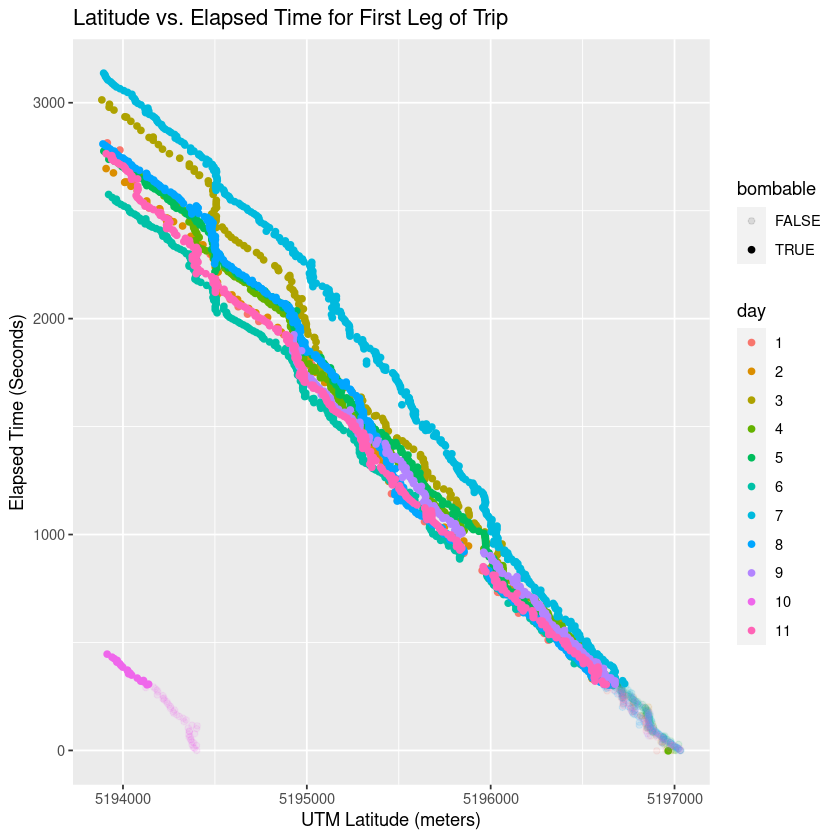

In [26]:
# now analyze in the time dimension
ggplot(reduced_df[reduced_df$elapsed < 4000, ], aes(x=lat_m, y=elapsed, color=day, alpha=bombable)) +
    geom_point() +
    labs(title="Latitude vs. Elapsed Time for First Leg of Trip",
         y="Elapsed Time (Seconds)",
         x="UTM Latitude (meters)")

Warning message:
“Using alpha for a discrete variable is not advised.”
Warning message:
“Removed 2019 rows containing missing values (geom_point).”


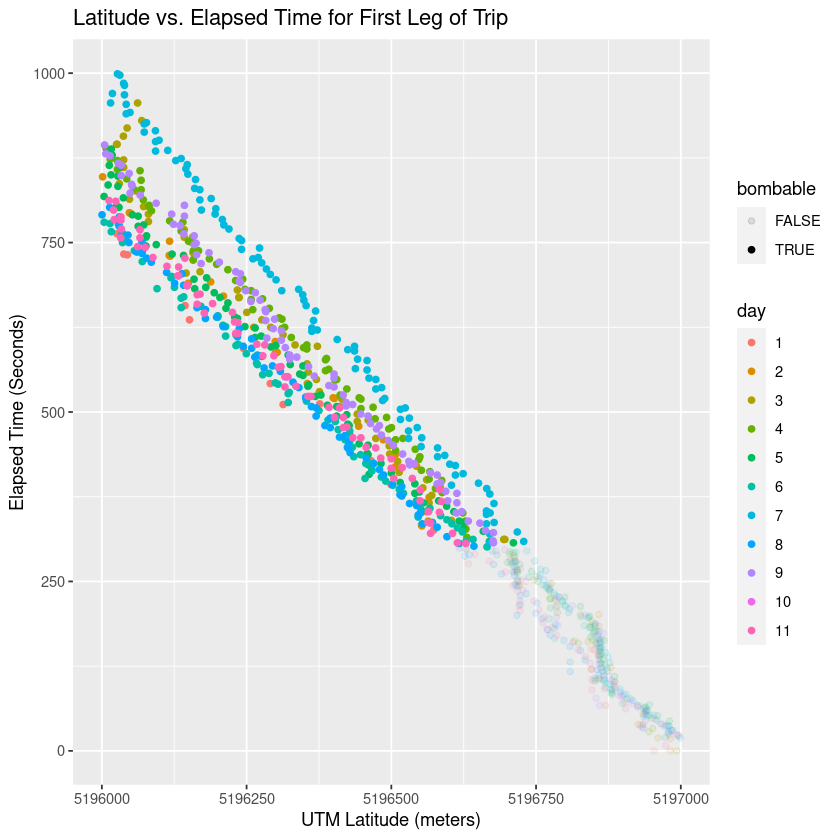

In [27]:
# now analyze in the time dimension
ggplot(reduced_df[reduced_df$elapsed < 4000, ], aes(x=lat_m, y=elapsed, color=day, alpha=bombable)) +
    geom_point() +
    labs(title="Latitude vs. Elapsed Time for First Leg of Trip",
         y="Elapsed Time (Seconds)",
         x="UTM Latitude (meters)") +
    ylim(0, 1000) +
    xlim(5196000, 5197000)

## Kalman Smoother

[1] 7.635359
[1] 35.175


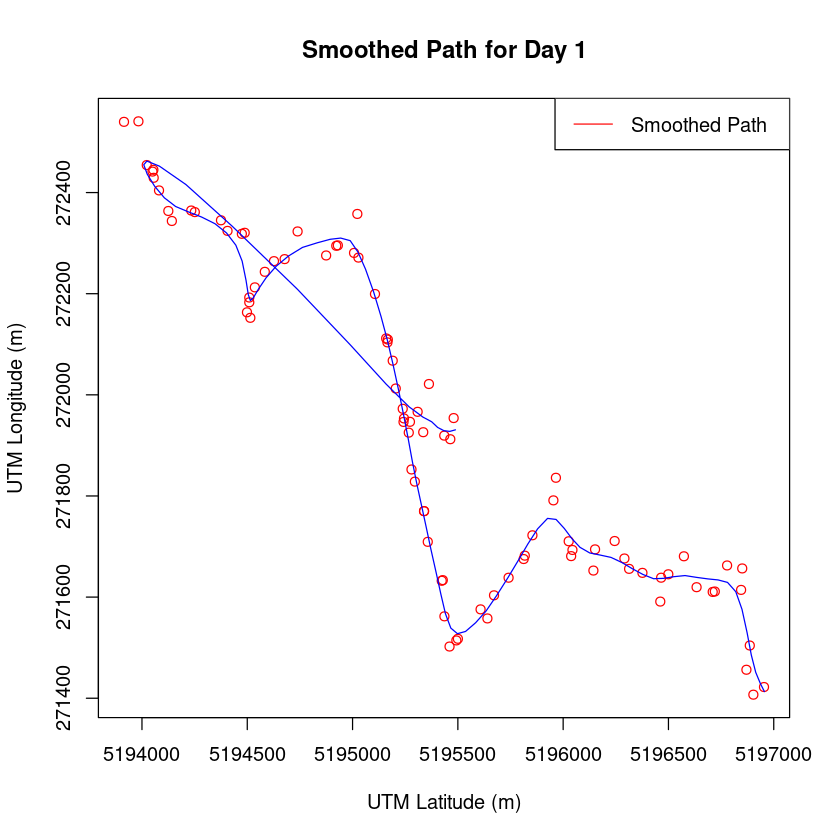

[1] 21.91057


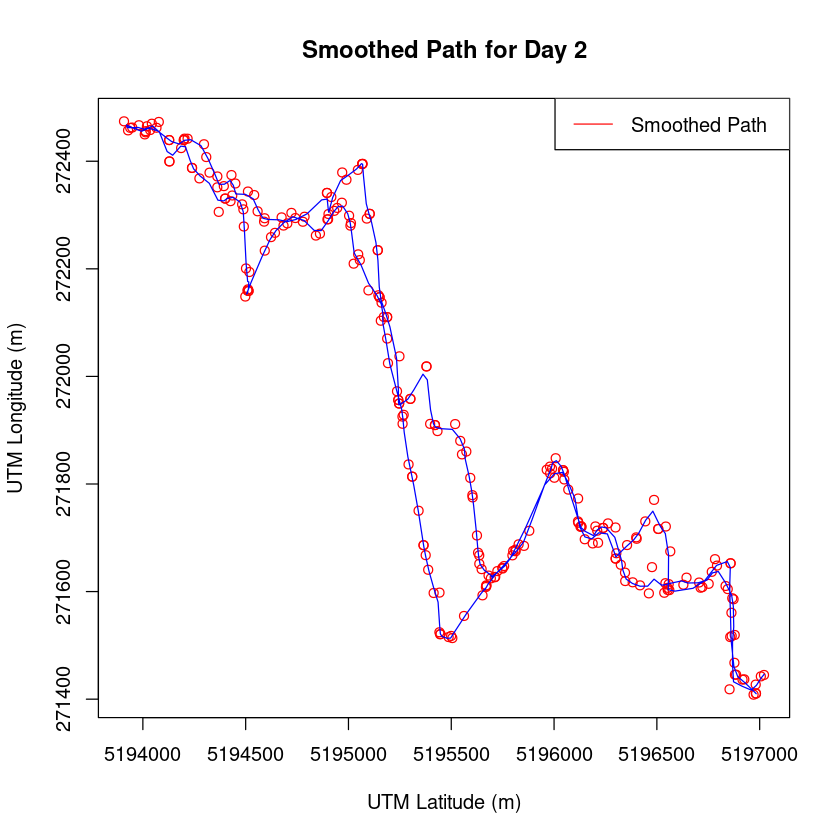

[1] 13.39111


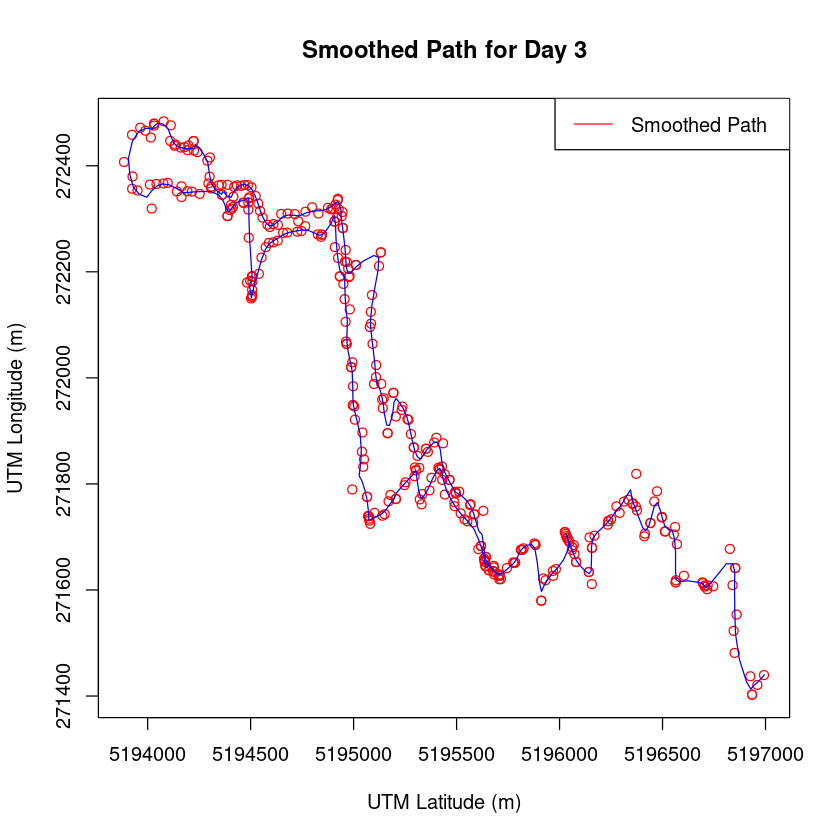

[1] 8.472561


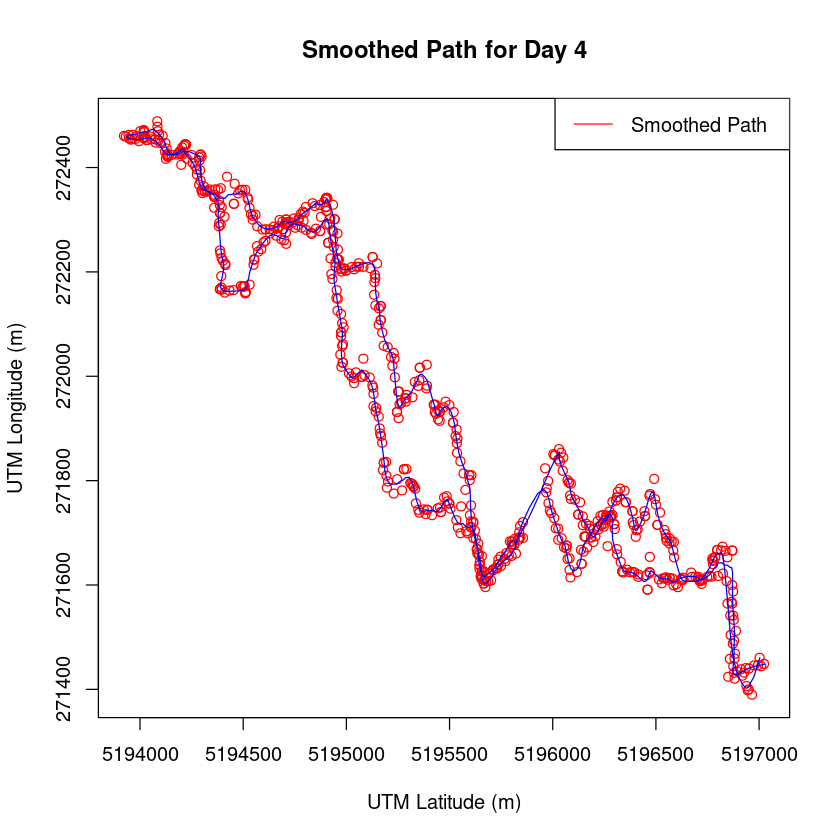

[1] 7.668508


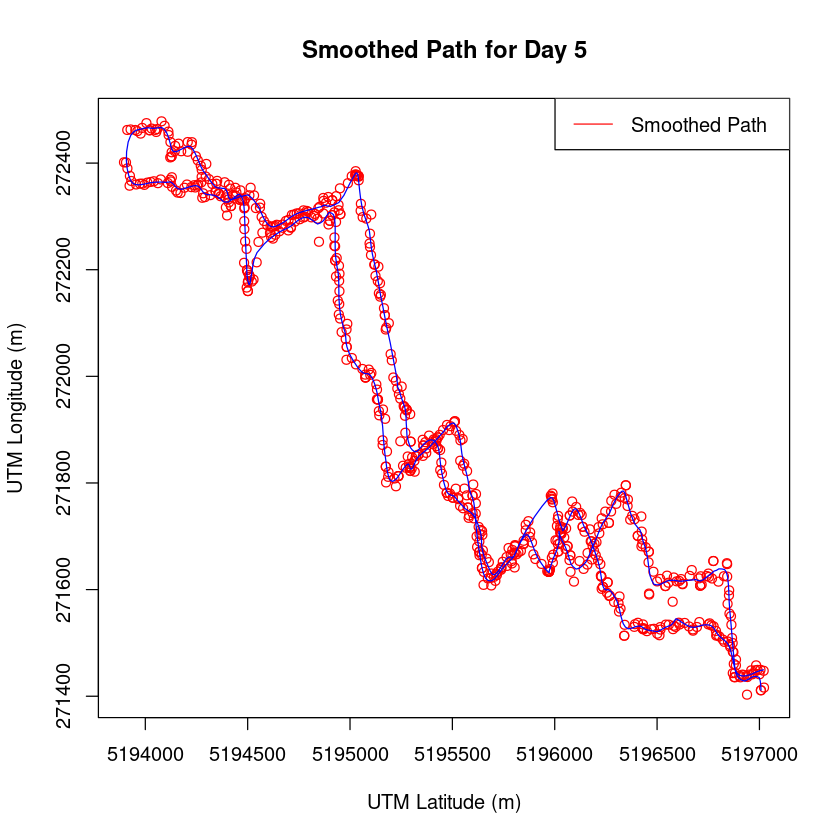

[1] 7.172702


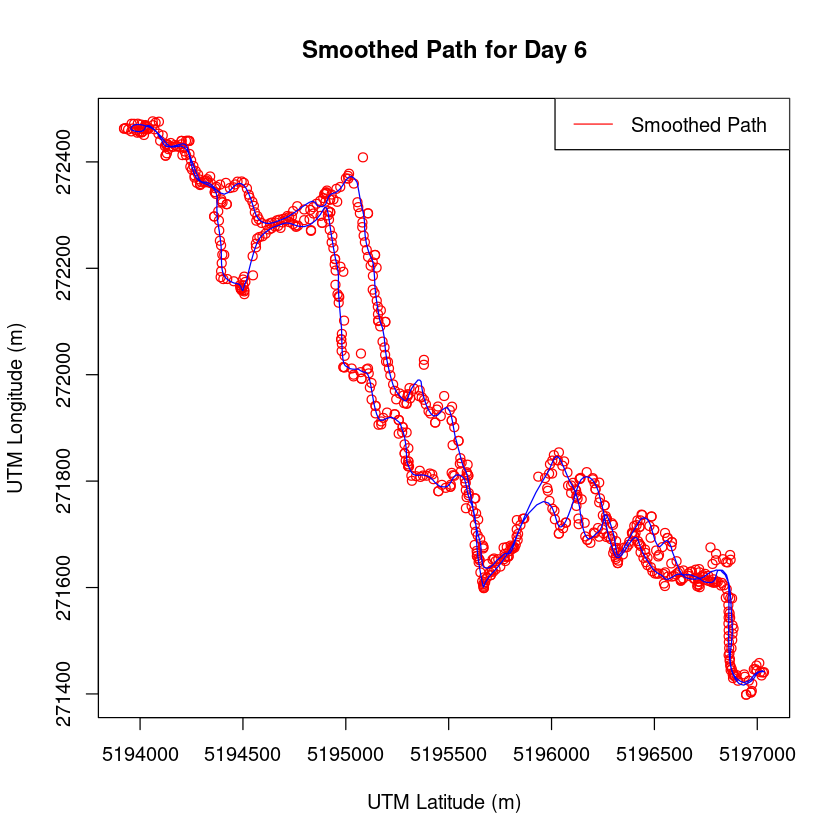

[1] 7.433649


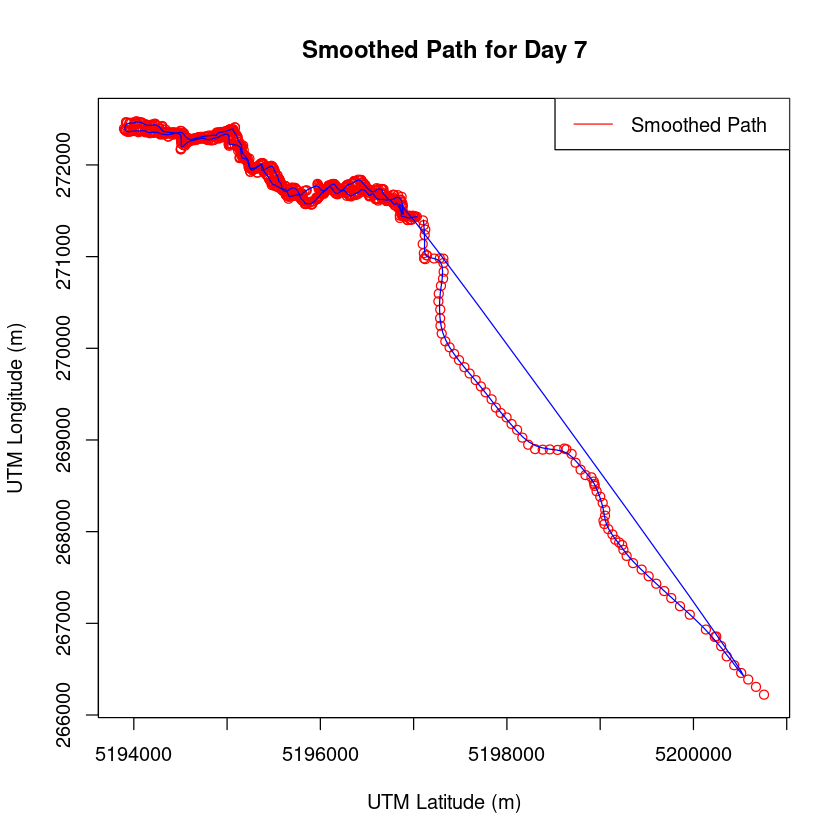

[1] 7.738292


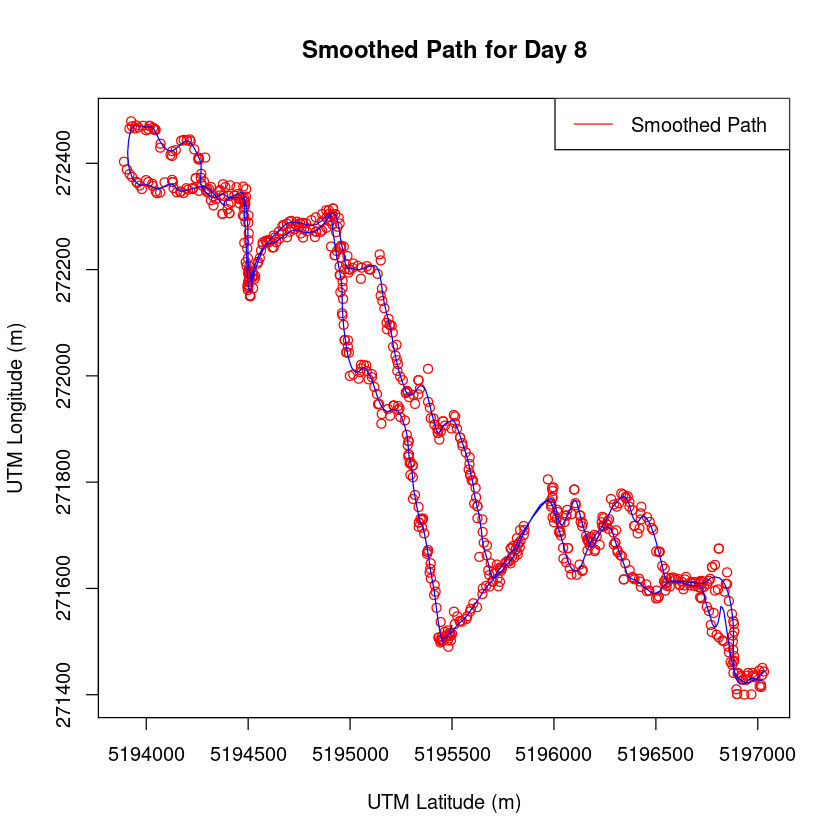

[1] 7.209738


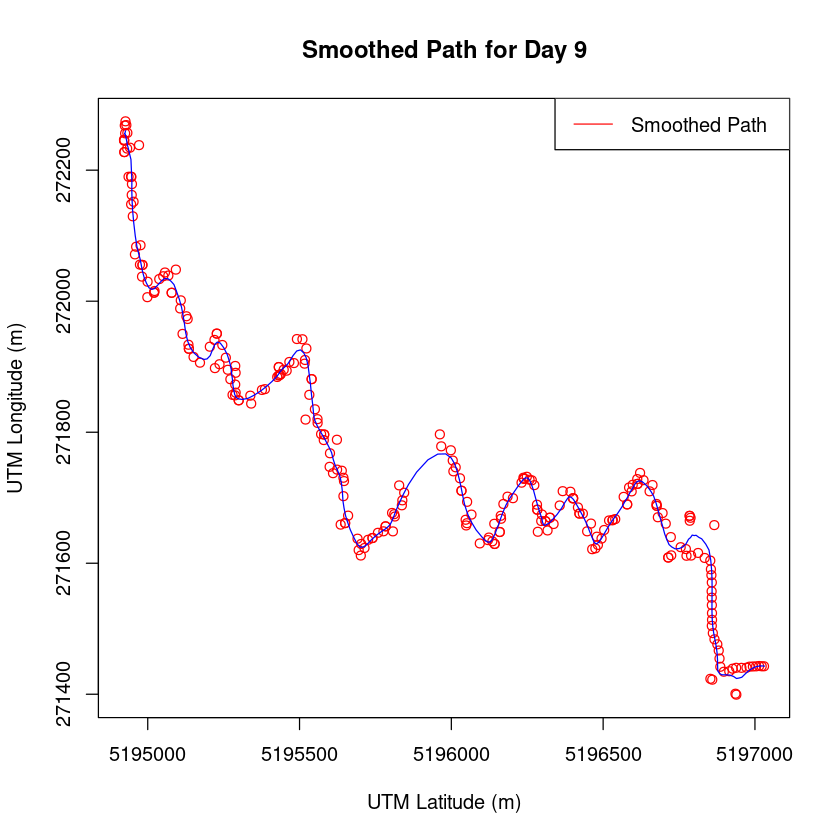

[1] 7.311475


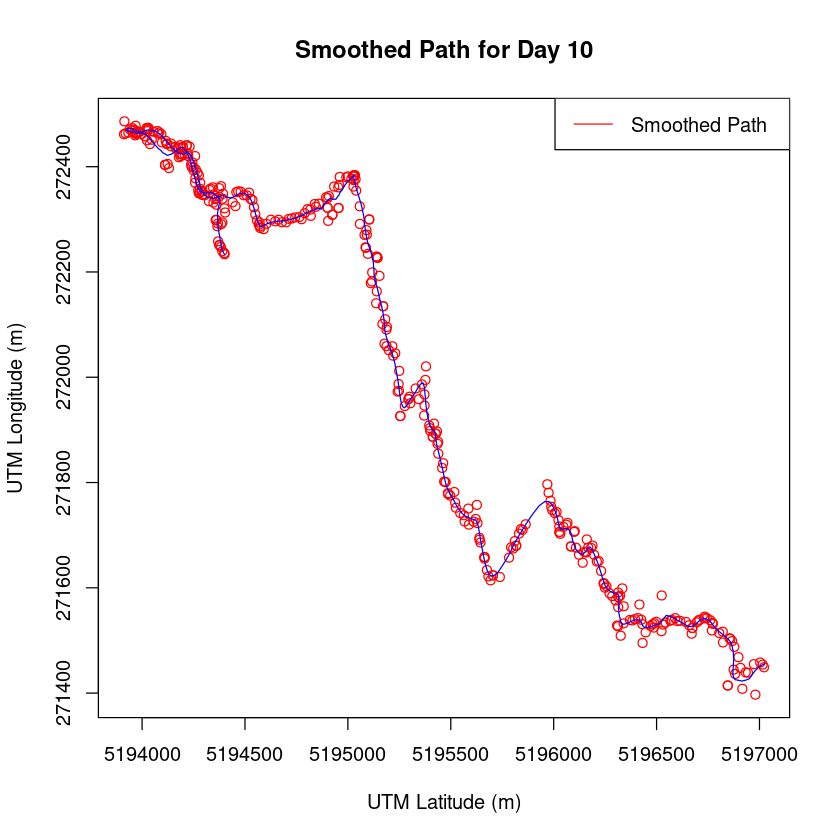

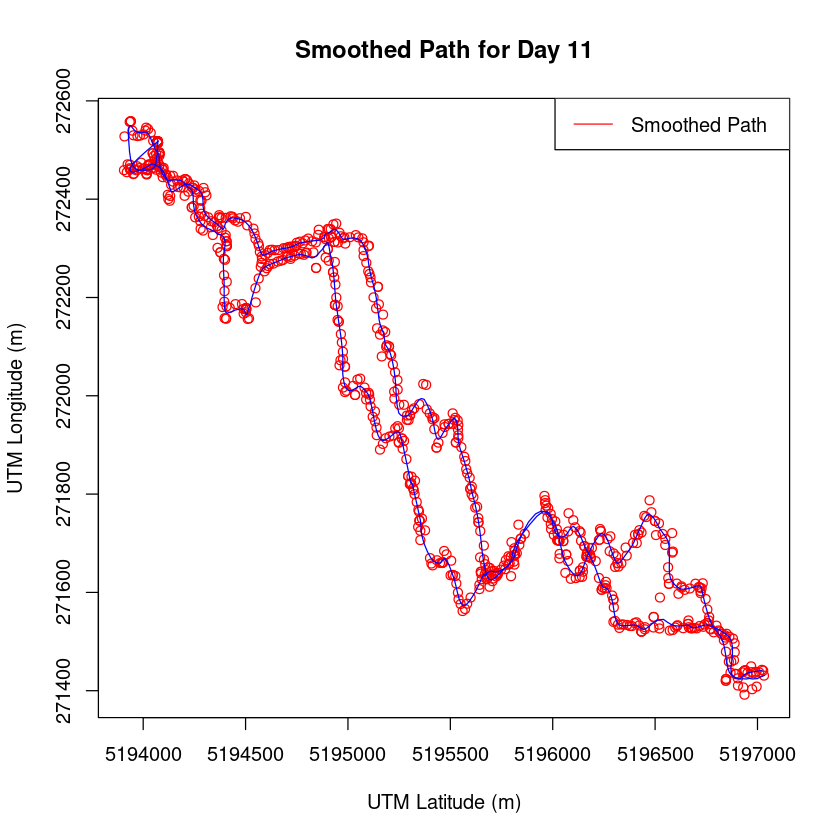

In [73]:
library("dlm")
gps_variance <- 20^2
v_mat <- diag(rep(gps_variance, 2))
avg_walk_speed_m_per_sec <- 1.4  # https://en.wikipedia.org/wiki/Walking
# now smooth per day
reduced_df$smooth_lat_m <- NA
reduced_df$smooth_long_m <- NA
reduced_df$speed <- NA
for (day in levels(factor(reduced_df$day))) {
    # estimate dt for every day
    dt <- max(data[data$elapsed < 4000, ]$elapsed)/length(data[data$elapsed < 4000, ]$elapsed)
    print(dt)
    g_mat <- matrix(c(1, 0, dt, 0,
                      0, 1, 0, dt,
                      0, 0, 1, 0,
                      0, 0, 0, 1), byrow=TRUE, ncol=4)
    data <- reduced_df[reduced_df$day == day, ]
    dlm_spec <- dlm(
      FF= matrix(c(1, 0, 0, 0,   0, 1, 0, 0), byrow=T, nrow=2),
      GG= g_mat,
      V = v_mat,
      W = diag(c(5, 5, 1, 1)^2),
      m0 = matrix(c(data$long_m[1], data$lat_m[1], rep(avg_walk_speed_m_per_sec / dt, 2)),
                  ncol=1), # A vector by R defaults is a k by 1 matrix
      C0 = diag(rep(10^2, 4)))
    dlm_filter_mod <- dlmFilter(cbind(data$long_m, data$lat_m), dlm_spec)
    dlm_smooth_mod <- dlmSmooth(dlm_filter_mod)
    smoothed <- dlm_smooth_mod$s
    plot(data$lat_m, data$long_m, col="red", xlab="UTM Latitude (m)", ylab="UTM Longitude (m)",
         main=paste("Smoothed Path for Day", day))
    lines(smoothed[, 2], smoothed[, 1], col="blue")
    legend("topright", legend=c("Smoothed Path"), col=c("red"), lty=1)
    reduced_df$smooth_lat_m[reduced_df$day == day] <- smoothed[, 2][2:length(smoothed[, 2])]
    reduced_df$smooth_long_m[reduced_df$day == day] <- smoothed[, 1][2:length(smoothed[, 2])]
    reduced_df$speed[reduced_df$day == day] <- sqrt(dlm_smooth_mod$s[, 3]^2 + dlm_smooth_mod$s[, 4]^2)[2:length(smoothed[, 2])]
}

In [70]:
head(reduced_df)

,index,time,elapsed,longitude,latitude,day,lat_m,long_m,temperature,stationary,bombable,smooth_lat_m,smooth_long_m,speed
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>
20200818114606.geojson1,1,1597773042,0,-114.0003,46.88678,1,5196954,271422.2,79.77000,TRUE,FALSE,5196936,271429.2,4.178285
20200818114606.geojson2,2,1597773040,-2,-114.0005,46.88632,1,5196903,271407.1,79.76667,FALSE,FALSE,5196914,271451.2,5.189669
20200818114606.geojson3,3,1597773109,67,-113.9999,46.88604,1,5196870,271456.3,79.88167,FALSE,FALSE,5196893,271485.6,6.051852
20200818114606.geojson4,4,1597773144,102,-113.9992,46.88620,1,5196886,271504.3,79.94000,FALSE,FALSE,5196874,271529.4,6.409193
20200818114606.geojson5,5,1597773192,150,-113.9978,46.88587,1,5196845,271614.3,80.01000,FALSE,FALSE,5196849,271575.8,5.883370
20200818114606.geojson6,6,1597773191,149,-113.9972,46.88593,1,5196850,271656.7,80.00917,FALSE,FALSE,5196820,271610.7,5.628755


## Time to Temperature Based on Slope

[1] 6.5000603 0.9776426 0.9273111 0.9443568 1.4051607 1.5398714 1.4232153
 [8] 1.6154375 1.4309414 1.5258787 1.6180425

[1] 81.03995 82.96875 74.89922 71.06940 75.74910 70.16785 80.44487 73.43362
 [9] 75.07587 76.94127 51.79683


Call:
lm(formula = slopes[2:length(slopes)] ~ avg_temps[2:length(slopes)])

Residuals:
    Min      1Q  Median      3Q     Max 
-0.4243 -0.1785  0.1048  0.1706  0.2769 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)  
(Intercept)                  2.27604    0.79354   2.868   0.0209 *
avg_temps[2:length(slopes)] -0.01277    0.01077  -1.186   0.2698  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2738 on 8 degrees of freedom
Multiple R-squared:  0.1495,	Adjusted R-squared:  0.04314 
F-statistic: 1.406 on 1 and 8 DF,  p-value: 0.2698


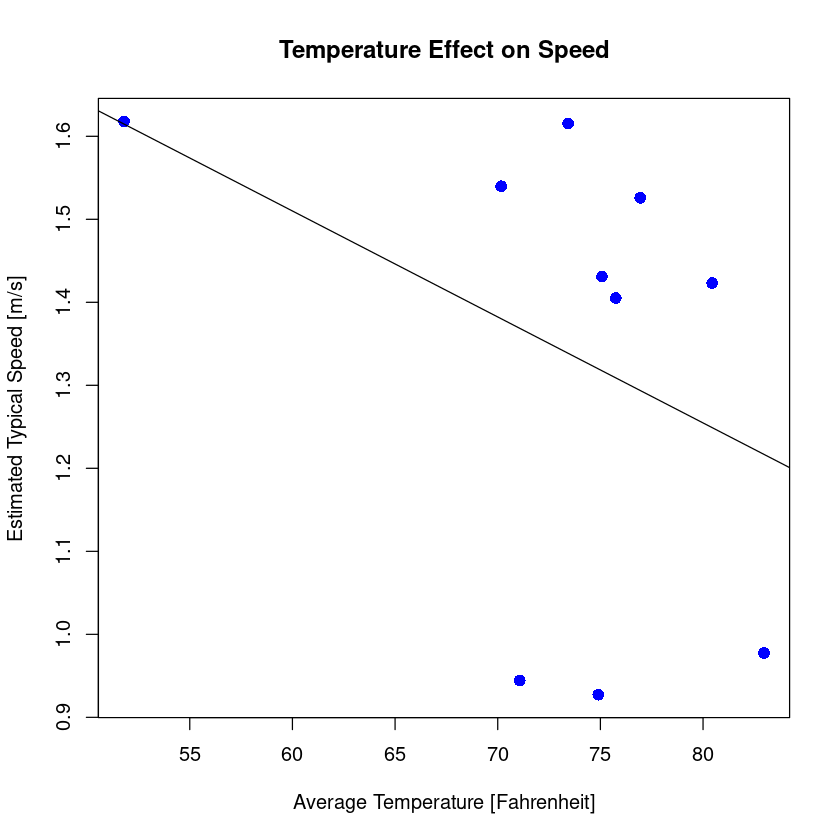

In [76]:
slopes <- unlist(map(levels(factor(reduced_df$day)), function(day) {
    data <- reduced_df[reduced_df$day == day, ]
    data <- data[data$elapsed < 4000, ]
    model <- lm(elapsed ~ lat_m, data=data)
    #print(model)
    model$coefficients[2]
    median(data$speed)
}))
avg_temps <- unlist(map(levels(factor(reduced_df$day)), function(day) {
    data <- reduced_df[reduced_df$day == day, ]
    data <- data[data$elapsed < 4000, ]
    mean(data$temperature)
}))
slopes
avg_temps
plot(avg_temps[2:length(slopes)], slopes[2:length(slopes)], pch=16, cex=1.3, col="blue", main="Temperature Effect on Speed",
     xlab="Average Temperature [Fahrenheit]", ylab="Estimated Typical Speed [m/s]")
abline(lm(slopes[2:length(slopes)] ~ avg_temps[2:length(slopes)]))
summary(lm(slopes[2:length(slopes)] ~ avg_temps[2:length(slopes)]))

## Predict Elapsed Time Differential Based on Latitude

In [77]:
real_dist <- function(long1, lat1, long2, lat2) {
    return(sqrt((long1 - long2)^2 + (lat1 - lat2)^2))
}

In [78]:
lat_vals <- seq(5194000, 5197000, by=10)

allowlist_days <- c(1:8,11)

elapsed_per_lat <- map(lat_vals, function(lat) {
    unlist(map(allowlist_days, function(day) {
        days_data <- reduced_df[reduced_df$elapsed < 4000, ]
        days_data <- days_data[days_data$day == day, ]
        dists <- abs(days_data$lat_m - lat)
        return(days_data$elapsed[which.min(dists)])
    }))
})

temperature_per_lat <- map(lat_vals, function(lat) {
    unlist(map(allowlist_days, function(day) {
        days_data <- reduced_df[reduced_df$elapsed < 4000, ]
        days_data <- days_data[days_data$day == day, ]
        dists <- abs(days_data$lat_m - lat)
        return(days_data$temperature[which.min(dists)])
    }))
})
names(elapsed_per_lat) <- lat_vals
names(temperature_per_lat) <- lat_vals

5194000  5194010  5194020  5194030  5194040  5194050 
2757.444 2737.556 2732.111 2726.444 2725.000 2721.000

,temperature,elapsed,latitude,day,mean_elapsed,elapsed_diff
,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
51940001,82.20250,2781,5194000,1,2757.444,23.55556
51940002,84.25111,2631,5194000,2,2757.444,-126.44444
51940003,77.45333,2935,5194000,3,2757.444,177.55556
51940004,72.83472,2738,5194000,4,2757.444,-19.44444
51940005,77.16500,2704,5194000,5,2757.444,-53.44444
51940006,71.07556,2521,5194000,6,2757.444,-236.44444



Call:
lm(formula = elapsed_diff ~ latitude + mean_elapsed * log(temperature), 
    data = temperature_train_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-239.49  -67.92   -2.60   32.79  373.33 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    1.101e+05  3.176e+05   0.347    0.729    
latitude                      -2.120e-02  6.112e-02  -0.347    0.729    
mean_elapsed                  -8.227e-01  1.108e-01  -7.428 1.47e-13 ***
log(temperature)               3.067e+01  3.278e+01   0.935    0.350    
mean_elapsed:log(temperature)  1.856e-01  2.042e-02   9.087  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 116.5 on 2704 degrees of freedom
Multiple R-squared:  0.1212,	Adjusted R-squared:  0.1199 
F-statistic: 93.19 on 4 and 2704 DF,  p-value: < 2.2e-16


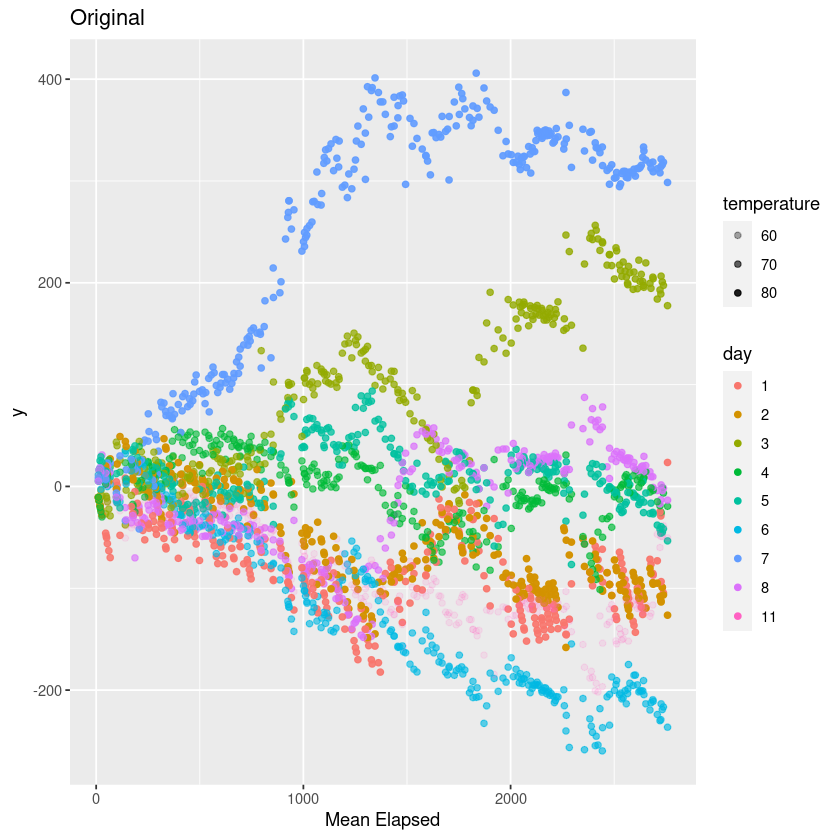

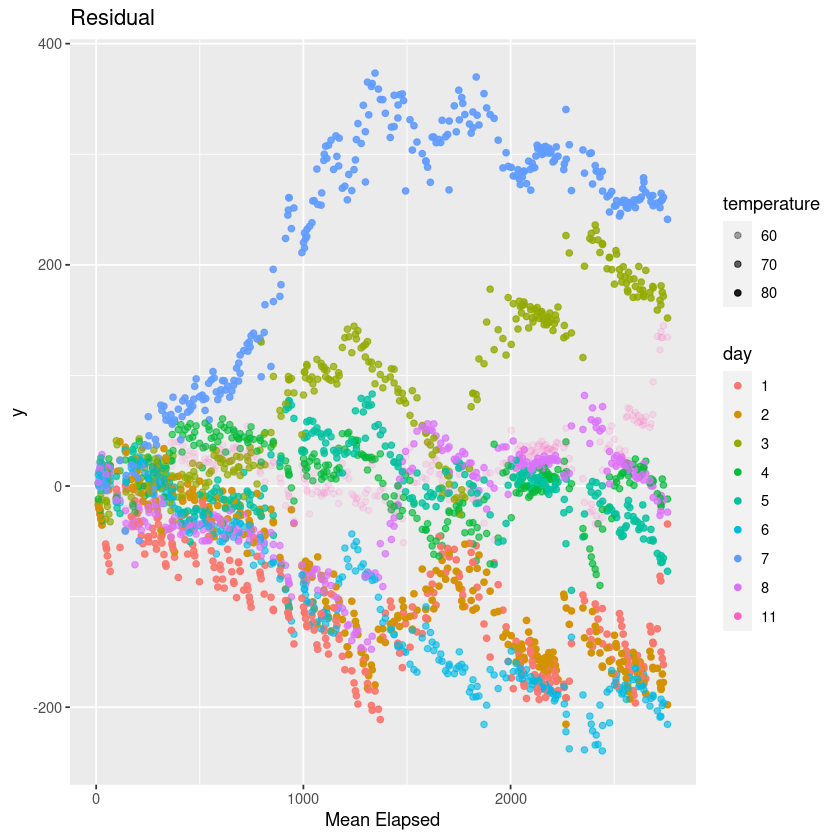

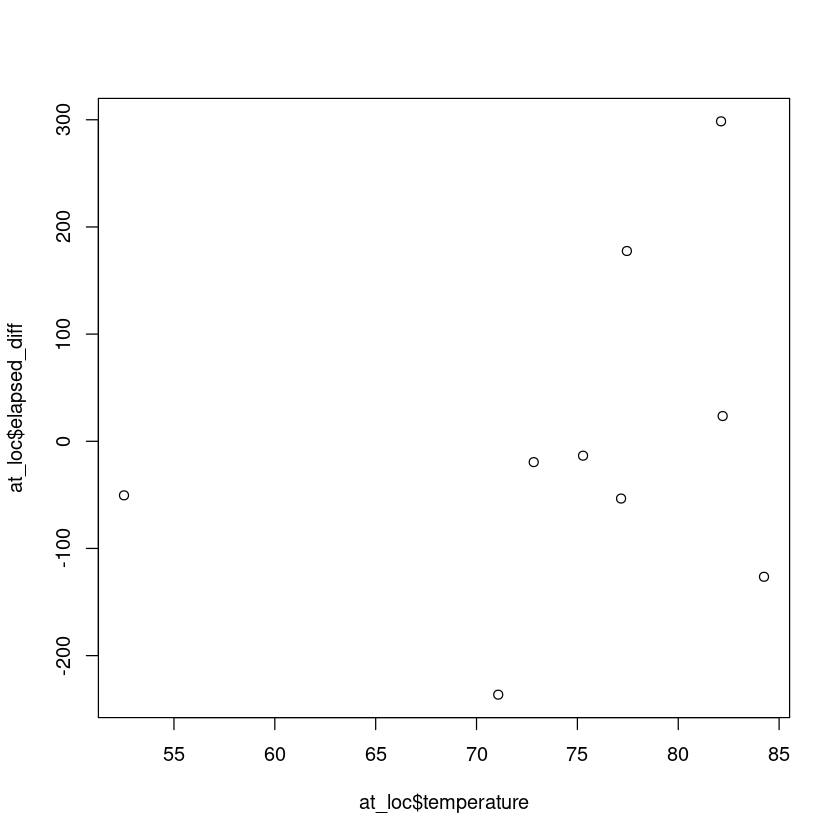

In [79]:
mean_elapsed <- unlist(map(elapsed_per_lat, function(el) {mean(el)}))
temperature_train_df <- data.frame(temperature=unlist(temperature_per_lat),
                                   elapsed=unlist(elapsed_per_lat),
                                   latitude=unlist(map(lat_vals, function(lat) {rep(lat, 9)})),
                                   day=factor(unlist(map(lat_vals, function(lat) {allowlist_days}))),
                                   mean_elapsed=unlist(map(mean_elapsed, function(el) {rep(el, 9)})),
                                   elapsed_diff=unlist(map(names(elapsed_per_lat), function(name) {
                                       elapsed_per_lat[[name]] - mean_elapsed[name]
                                   })))
head(mean_elapsed)
head(temperature_train_df)
ggplot(temperature_train_df, aes(x=mean_elapsed, y=elapsed_diff, color=day, alpha=temperature)) +
    geom_point() +
    labs(title="Original",
         y="y",
         x="Mean Elapsed")

model <- lm(elapsed_diff ~ latitude + mean_elapsed*log(temperature), temperature_train_df)
summary(model)
temperature_train_df$rectified_diff <- model$residuals

ggplot(temperature_train_df, aes(x=mean_elapsed,
                                 y=rectified_diff,
                                 color=day, alpha=temperature)) +
    geom_point() +
    labs(title="Residual",
         y="y",
         x="Mean Elapsed")

at_loc <- temperature_train_df[temperature_train_df$latitude == 5194000, ]
plot(at_loc$temperature, at_loc$elapsed_diff)

### Temperature's Effect on Speed

I will use a rough approximation of speed and then cut out 3 sigma outliers. I will then perform a regression.

In [80]:
# TODO

# Model Building

In [85]:
predict <- function(start_time, start_long, start_lat, train_data) {
    GRID_RESOLUTION = 2 # 2 meters
    #days <- c(1:8,11)
    days <- as.integer(levels(factor(train_data$day)))
    # now get train data slice
    lats <- seq(5193900, 5196700, by=GRID_RESOLUTION)
    train_data <- reduced_df[reduced_df$elapsed < 4000, ] # only keep data from first leg
    # only keep bombable points
    train_data <- train_data[train_data$bombable == TRUE, ] # don't train on points that can't be used
    DAYS <- 11
    # now cache certain views
    cache_longitudes <- list()
    cache_elapsed <- list()
    for (day in days) {
        cache_longitudes[[day]] <- train_data$long_m[train_data$day == day]
        cache_elapsed[[day]] <- train_data$elapsed[train_data$day == day]
    }
    # now get densities
    all_uncertainties <- unlist(map(1:length(lats), function(idx) {
        lat <- lats[idx]
        dists <- abs(train_data$lat_m - lat)
        day_idxes <- rep(NA, DAYS)
        latitude_diff <- rep(NA, DAYS)
        longitudes <- rep(NA, DAYS)
        elapsed <- rep(NA, DAYS)
        for (day in days) {
            day_idxes[day] <- which.min(dists[train_data$day == day])
            latitude_diff[day] <- dists[train_data$day == day][day_idxes[day]]
            longitudes[day] <- cache_longitudes[[day]][day_idxes[day]]
            elapsed[day] <- cache_elapsed[[day]][day_idxes[day]]
        }
        # Predict best longitudes and get their location uncertainty
        mean_long <- mean(longitudes, na.rm=TRUE)
        # go through every possible pairing and get the two with minimum uncertainty
        best_uncertainty <- Inf
        final_pred1 <- NA
        final_pred2 <- NA
        final_time1 <- NA
        final_time2 <- NA
        best_groupmask <- NA
        for (i in 1:(length(days)-1)) {
            for (j in (i+1):length(days)) {
                point1 <- longitudes[days[i]]
                point2 <- longitudes[days[j]]
                dists <- matrix(NA, ncol=2, nrow=DAYS)
                #print(dim(dists))
                #print(days)
                #print(length(longitudes))
                #print(length(abs(longitudes - point1)))
                #print(abs(longitudes - point1))
                dists[, 1] <- abs(longitudes - point1)
                dists[, 2] <- abs(longitudes - point2)
                parent <- apply(dists, 1, which.min)
                parent <- unlist(replace(parent, !sapply(parent, length), 0))
                #print(parent)
                # now get predicted point
                pred1 <- mean(longitudes[parent == 1])
                pred2 <- mean(longitudes[parent == 2])
                # now get uncertainty
                uncertainty1 <- sum(sqrt((longitudes[parent == 1] - pred1)^2 + latitude_diff[parent == 1]^2))
                uncertainty2 <- sum(sqrt((longitudes[parent == 2] - pred2)^2 + latitude_diff[parent == 2]^2))
                uncertainty <- (uncertainty1 + uncertainty2)/length(days)
                #uncertainty <- sum(total_uncertainty, na.rm=TRUE)/length(days)
                if (uncertainty < best_uncertainty) {
                    final_pred1 <- pred1
                    final_pred2 <- pred2
                    best_uncertainty <- uncertainty
                    best_groupmask <- parent
                }
            }
        }
        longitude_pred <- mean_long
        # Get position uncertainty
        #total_uncertainty <- sqrt((longitudes - mean_long)^2 + latitude_diff^2)
        #uncertainty <- sum(total_uncertainty, na.rm=TRUE)/length(days)
        # Now get time uncertainty
        final_time1 <- mean(elapsed[parent == 1], na.rm=TRUE)
        time_uncertainty <- sum(abs(elapsed[parent == 1] - final_time1), na.rm=TRUE)
        final_time2 <- mean(elapsed[parent == 2], na.rm=TRUE)
        time_uncertainty <- time_uncertainty +
                sum(abs(elapsed[parent == 2] - final_time2), na.rm=TRUE)
        time_uncertainty <- time_uncertainty/length(days)
        # Now return
        return(c(best_uncertainty, time_uncertainty, final_pred1, final_pred2, final_time1, final_time2))
    }))
    all_uncertainties <- matrix(all_uncertainties, ncol=6, byrow=TRUE)
    lat_uncertainties <- all_uncertainties[, 1]
    time_uncertainties <- all_uncertainties[, 2]
    # now pick the best points
    best_metric <- Inf
    best_lat_uncertainty <- NA
    best_time_uncertainty <- NA
    best_lat <- NA
    best_longs <- NA
    best_times <- NA
    for (i in 1:length(lats)) {
        metric <- time_uncertainties[i] + lat_uncertainties[i]*2
        if (metric < best_metric) {
            best_metric <- metric
            best_lat <- lats[i]
            best_longs <- all_uncertainties[i, 3:4]
            best_times <- all_uncertainties[i, 5:6]
            best_lat_uncertainty <- lat_uncertainties[i]
            best_time_uncertainty <- time_uncertainties[i]
        }
    }
    #cat("BEST:", best_lat_uncertainty, best_time_uncertainty, best_lat, best_longs, "\n")
    return(list(bomb1=list(utm_latitude=best_lat, utm_longitude=best_longs[1],
                  elapsed=best_times[1], time=start_time+best_times[1]),
             bomb2=list(utm_latitude=best_lat, utm_longitude=best_longs[2],
                  elapsed=best_times[2], time=start_time+best_times[2])))
}

In [86]:
to_utm <- function(long, lat) {
    spat_df <- SpatialPoints(coords=cbind(long, lat),
                                     proj4string=CRS("+proj=longlat +datum=WGS84 +units=m"))# This step converts the longitude/latitude -> UTM
    utm_df <- spTransform(spat_df, CRSobj = "+proj=utm +zone=12 +datum=WGS84 +units=m")
    utm_coords <- coordinates(utm_df)
    return(list(long=utm_coords[1, "long"], lat=utm_coords[1, "lat"]))
}

In [87]:
success_test <- function(prediction, test_data) {
    min_dist <- NA
    min_time <- NA
    for (i in c(1,2)) {
        #cat(prediction[[i]]$utm_longitude, prediction[[i]]$utm_latitude, prediction[[i]]$time, "\n")
        dists <- unlist(map(1:dim(test_data)[1], function(idx) {
            row <- test_data[idx, ]
            real_dist(row$long_m, row$lat_m, prediction[[i]]$utm_longitude, prediction[[i]]$utm_latitude)
        }))
        min_idx <- which.min(dists)
        time_diff <- abs(test_data$time[min_idx] - prediction[[i]]$time)
        # only update time if dist is smaller
        min_dist <- min(c(min_dist, min(dists)), na.rm=TRUE)
        if (is.na(min_time)) {
            min_time <- time_diff
        } else {
            if (min_dist == min(dists)) { # only update if we picked a new smallest dist
                min_time <- time_diff
            }
        }
        #min_time <- min(c(min_time, time_diff), na.rm=TRUE)
    }
    return(c(min_dist, min_time))
}

density <- function(long, lat, train_data) {
    # get nearest point for each day
    days <- levels(factor(train_data$day))
    dists <- unlist(map(days, function(day) {
        day_data <- train_data[train_data$day == day, ]
        dists <- unlist(map(1:dim(day_data)[1], function(idx) {
            row <- day_data[idx, ]
            real_dist(row$long_m, row$lat_m, long, lat)
        }))
        return(min(dists))
    }))
    return(sum(log(dists)))
}

test_model <- function(test_data, train_data) {
    test_data[]
    #start_time <- min(test_data$time)
    #start_long <- test_data$long_m[which.min(test_data$time)]
    #start_lat <- test_data$lat_m[which.min(test_data$time)]
    start_time <- test_data$time[1]
    start_long <- test_data$long_m[1]
    start_lat <- test_data$lat_m[1]
    prediction <- predict(start_time, start_long, start_lat, train_data)
    #print(prediction)
    margin <- success_test(prediction, test_data[test_data$elapsed < 4000, ])
    cat("Off by:", margin[1], "\n")
    cat("With time error:", margin[2], "\n")
    return(margin)
}

In [88]:
valid_days <- c(1:8,11)
performances <- c()
for (day in valid_days) {
    cat("Test", day, "\n")
    train_days <- valid_days[-which(valid_days == day)]
    print(train_days)
    result <- test_model(reduced_df[reduced_df$day == day, ],
               reduced_df[reduced_df$day %in% train_days, ])
    performances <- c(performances, day, result)
}
perf <- matrix(performances, ncol=3, byrow=TRUE)
colnames(perf) <- c("Test Day", "Distance Error (m)", "Time Error (s)")
perf

Test 1 
[1]  2  3  4  5  6  7  8 11
Off by: 4.487454 
With time error: 50.57143 
Test 2 
[1]  1  3  4  5  6  7  8 11
Off by: 13.55073 
With time error: 4.285714 
Test 3 
[1]  1  2  4  5  6  7  8 11
Off by: 3.434456 
With time error: 7.714286 
Test 4 
[1]  1  2  3  5  6  7  8 11
Off by: 5.970654 
With time error: 44.14286 
Test 5 
[1]  1  2  3  4  6  7  8 11
Off by: 10.4613 
With time error: 48 
Test 6 
[1]  1  2  3  4  5  7  8 11
Off by: 5.484424 
With time error: 37 
Test 7 
[1]  1  2  3  4  5  6  8 11
Off by: 16.5546 
With time error: 72.85714 
Test 8 
[1]  1  2  3  4  5  6  7 11
Off by: 3.421261 
With time error: 31.71429 
Test 11 
[1] 1 2 3 4 5 6 7 8
Off by: 5.341157 
With time error: 33.66667 


Test Day,Distance Error (m),Time Error (s)
1,4.487454,50.571429
2,13.550726,4.285714
3,3.434456,7.714286
4,5.970654,44.142857
5,10.461304,48.000000
6,5.484424,37.000000
7,16.554596,72.857143
8,3.421261,31.714286
11,5.341157,33.666667


BEST: 7.171384 20.22222 5196575 271684.1 271619.9 


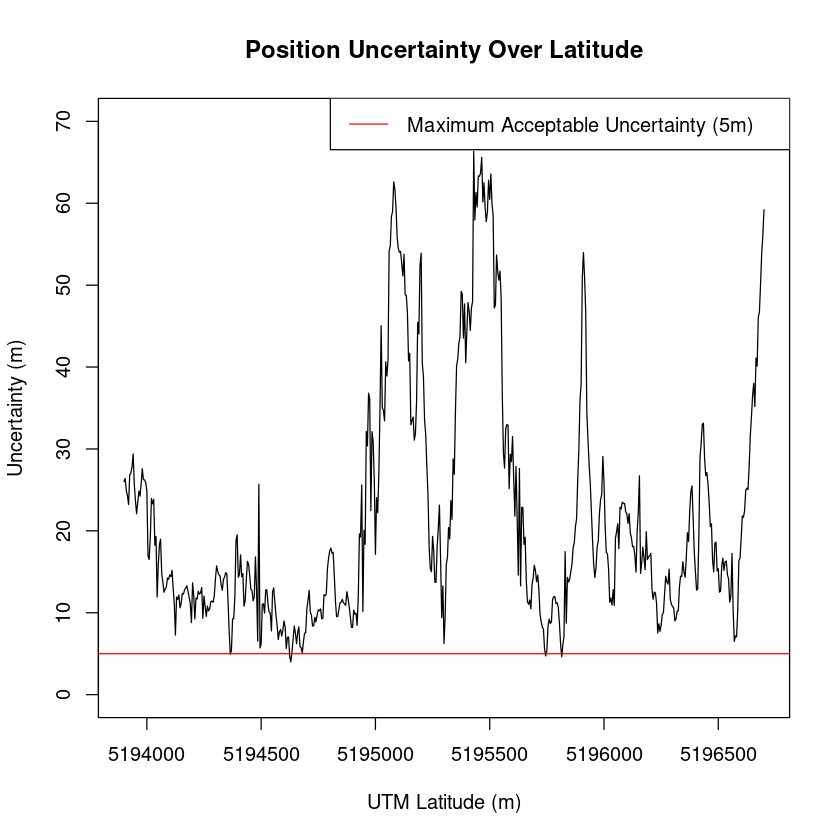

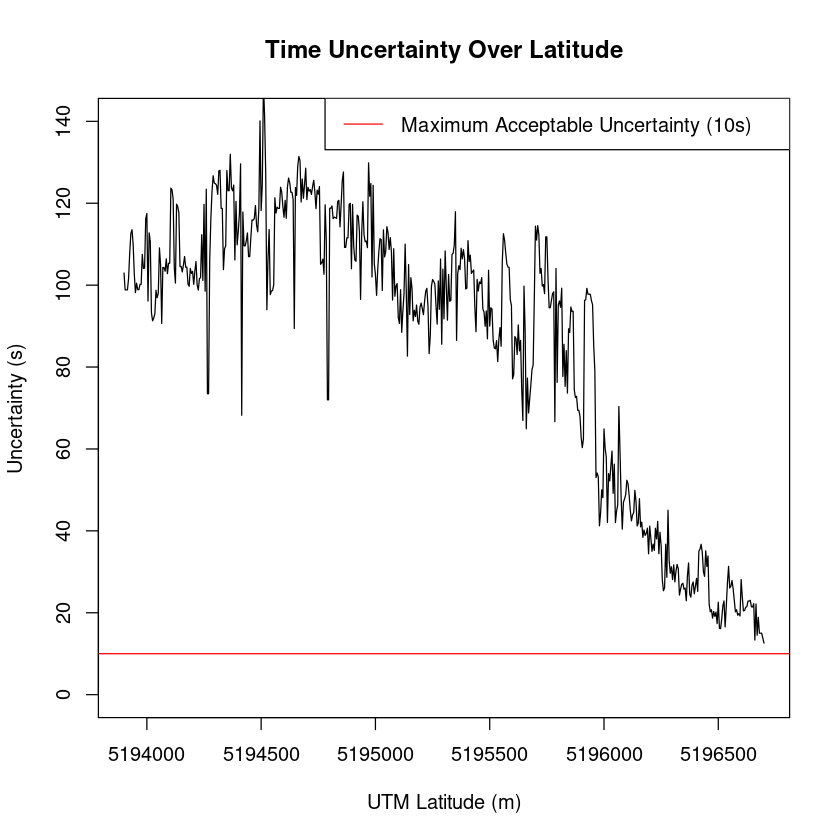

In [43]:
# METHOD: GO ALONG LATITUDE AND PLOT UNCERTAINTY
days <- c(1:8,11)
# now get train data slice
lats <- seq(5193900, 5196700, by=5)
train_data <- reduced_df[reduced_df$elapsed < 4000, ]
# only keep bombable points
train_data <- train_data[train_data$bombable == TRUE, ]
train_data <- train_data[reduced_df$day != 9, ]
train_data <- train_data[reduced_df$day != 10, ]
DAYS <- 11
# now cache certain views
cache_longitudes <- list()
cache_elapsed <- list()
for (day in days) {
    cache_longitudes[[day]] <- train_data$long_m[train_data$day == day]
    cache_elapsed[[day]] <- train_data$elapsed[train_data$day == day]
}
# now get densities
all_uncertainties <- unlist(map(1:length(lats), function(idx) {
    lat <- lats[idx]
    dists <- abs(train_data$lat_m - lat)
    day_idxes <- rep(NA, DAYS)
    latitude_diff <- rep(NA, DAYS)
    longitudes <- rep(NA, DAYS)
    elapsed <- rep(NA, DAYS)
    for (day in days) {
        day_idxes[day] <- which.min(dists[train_data$day == day])
        latitude_diff[day] <- dists[train_data$day == day][day_idxes[day]]
        longitudes[day] <- cache_longitudes[[day]][day_idxes[day]]
        elapsed[day] <- cache_elapsed[[day]][day_idxes[day]]
    }
    # TODO: PREDICT BEST 2 LONGITUDES
    # Predict best longitudes and get their location uncertainty
    mean_long <- mean(longitudes, na.rm=TRUE)
    # go through every possible pairing and get the two with minimum uncertainty
    best_uncertainty <- Inf
    final_pred1 <- NA
    final_pred2 <- NA
    best_groupmask <- NA
    for (i in 1:(length(days)-1)) {
        for (j in (i+1):length(days)) {
            point1 <- longitudes[days[i]]
            point2 <- longitudes[days[j]]
            dists <- matrix(NA, ncol=2, nrow=DAYS)
            dists[, 1] <- abs(longitudes - point1)
            dists[, 2] <- abs(longitudes - point2)
            parent <- apply(dists, 1, which.min)
            parent <- unlist(replace(parent, !sapply(parent, length), 0))
            #print(parent)
            # now get predicted point
            pred1 <- mean(longitudes[parent == 1])
            pred2 <- mean(longitudes[parent == 2])
            # now get uncertainty
            uncertainty1 <- sum(sqrt((longitudes[parent == 1] - pred1)^2 + latitude_diff[parent == 1]^2))
            uncertainty2 <- sum(sqrt((longitudes[parent == 2] - pred2)^2 + latitude_diff[parent == 2]^2))
            uncertainty <- (uncertainty1 + uncertainty2)/length(days)
            #uncertainty <- sum(total_uncertainty, na.rm=TRUE)/length(days)
            if (uncertainty < best_uncertainty) {
                final_pred1 <- pred1
                final_pred2 <- pred2
                best_uncertainty <- uncertainty
                best_groupmask <- parent
            }
        }
    }
    longitude_pred <- mean_long
    # Get position uncertainty
    #total_uncertainty <- sqrt((longitudes - mean_long)^2 + latitude_diff^2)
    #uncertainty <- sum(total_uncertainty, na.rm=TRUE)/length(days)
    # Now get time uncertainty
    time_uncertainty <- sum(abs(elapsed[parent == 1] - mean(elapsed[parent == 1], na.rm=TRUE)), na.rm=TRUE)
    time_uncertainty <- time_uncertainty +
            sum(abs(elapsed[parent == 2] - mean(elapsed[parent == 2], na.rm=TRUE)), na.rm=TRUE)
    time_uncertainty <- time_uncertainty/length(days)
    # Now return
    return(c(best_uncertainty, time_uncertainty, final_pred1, final_pred2))
}))
all_uncertainties <- matrix(all_uncertainties, ncol=4, byrow=TRUE)
lat_uncertainties <- all_uncertainties[, 1]
time_uncertainties <- all_uncertainties[, 2]
# now pick the best points
best_metric <- Inf
best_lat_uncertainty <- NA
best_time_uncertainty <- NA
best_lat <- NA
best_longs <- NA
for (i in 1:length(lats)) {
    metric <- time_uncertainties[i] + lat_uncertainties[i]*2
    if (metric < best_metric) {
        best_metric <- metric
        best_lat <- lats[i]
        best_longs <- all_uncertainties[i, 3:4]
        best_lat_uncertainty <- lat_uncertainties[i]
        best_time_uncertainty <- time_uncertainties[i]
    }
}
cat("BEST:", best_lat_uncertainty, best_time_uncertainty, best_lat, best_longs, "\n")
# plot for uncertainties over latitudes
plot(lats, lat_uncertainties, type="l", xlab="UTM Latitude (m)",
     ylab="Uncertainty (m)", main="Position Uncertainty Over Latitude",
     ylim=c(0,70))
abline(h=5, col="red")
legend("topright", legend=c("Maximum Acceptable Uncertainty (5m)"), col=c("red"), lty=1)
plot(lats, time_uncertainties, type="l", xlab="UTM Latitude (m)",
     ylab="Uncertainty (s)", main="Time Uncertainty Over Latitude",
     ylim=c(0,140))
abline(h=10, col="red")
legend("topright", legend=c("Maximum Acceptable Uncertainty (10s)"), col=c("red"), lty=1)

Warning message:
“Using alpha for a discrete variable is not advised.”
Warning message:
“Removed 29 rows containing missing values (geom_point).”


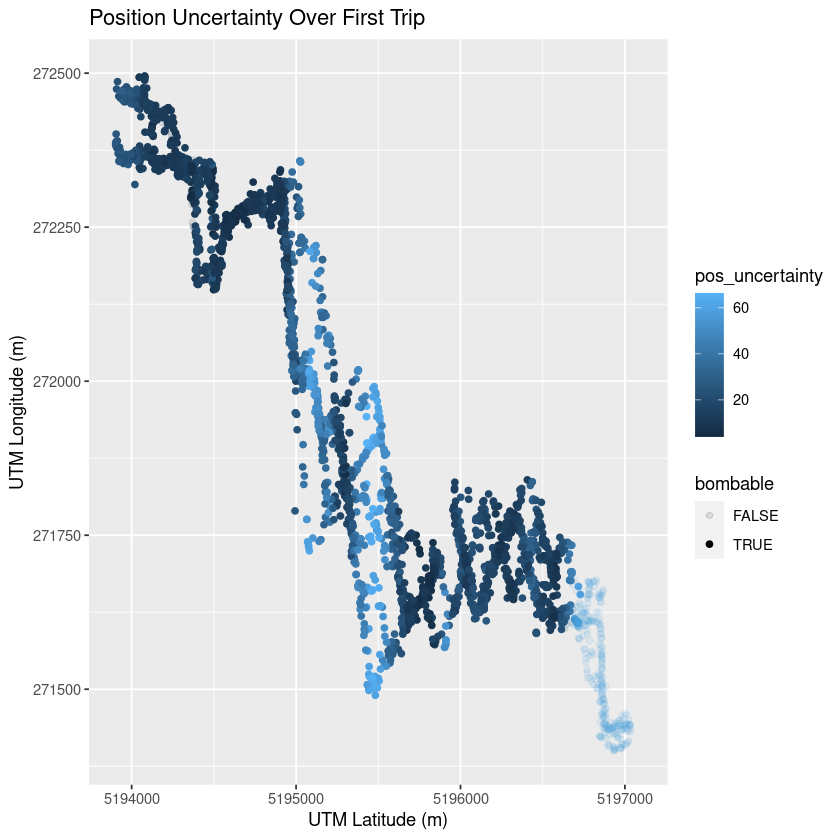

In [48]:
# plot hiding the non-bombable points
bombable <- ifelse(reduced_df$bombable, 0.9, 0.1)
uncert_df <- reduced_df[reduced_df$elapsed < 4000, ]
uncert_df$pos_uncertainty <- unlist(map(uncert_df$lat_m, function(lat) {
    idx <- which.min(abs(lats - lat))
    lat_uncertainties[idx]
}))
ggplot(uncert_df, aes(x=lat_m, y=long_m, color=pos_uncertainty, alpha=bombable)) +
    geom_point() +
    ylim(271400, 272500) +
    xlim(5193900, 5197100) +
    labs(title="Position Uncertainty Over First Trip",
         y="UTM Longitude (m)", x="UTM Latitude (m)")